In [2]:
import pandas as pd
import numpy as np
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import boxcox, zscore
from scipy.special import inv_boxcox
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    train_test_split,
    cross_val_score,
    StratifiedKFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import (
    LinearRegression,
    LassoCV,
    RidgeCV,
    Lasso,
    Ridge,
    ElasticNet,
)
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA

In [44]:
sns.set_style("darkgrid")
matplotlib.rcParams["font.size"] = 14
matplotlib.rcParams["figure.figsize"] = (10, 6)
matplotlib.rcParams["figure.facecolor"] = "#00000000"

In [45]:
medical_df = pd.read_csv("medical.csv")

medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [46]:
medical_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [47]:
cat_col = medical_df.select_dtypes(include=["object"]).columns.to_list()

num_col = medical_df.select_dtypes(include=["int64", "float64"]).columns.to_list()

# num_col.remove("charges")

print(cat_col, num_col)

['sex', 'smoker', 'region'] ['age', 'bmi', 'children', 'charges']


## Summary statistics for the numerical values

In [48]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Summary statistics for categorical values

There are less smokers in  the collected data. Hence in the train test split, all these should be represented in the data

In [49]:
medical_df["sex"].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [50]:
medical_df["region"].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

In [51]:
medical_df["smoker"].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [52]:
medical_df["children"].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

## Data Cleaning

### Duplicates
One duplicate found and removed

### missing values
No missing values found

In [53]:
medical_df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [54]:
medical_df[medical_df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [55]:
medical_df.duplicated().value_counts()

False    1337
True        1
dtype: int64

In [56]:
medical_df.drop_duplicates(inplace=True)
medical_df.duplicated().value_counts()

False    1337
dtype: int64

## Data Visualization and Correlation matrix

The distribution of the data is non-Gausian. 

The correlation plot shows a weak correlation between between the target, chargess and the predictors. This shows that these set of features are not informative and hence requires further fine-tunning by means of feature engineering

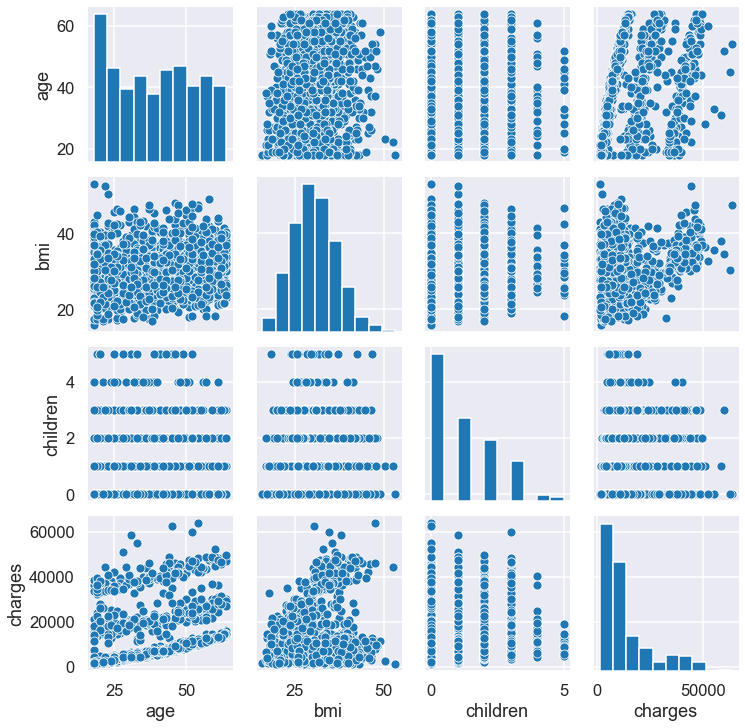

In [57]:
sns.set_context("talk")

sns.pairplot(medical_df[num_col])  # hue="children")

plt.show()

In [58]:
corr = medical_df.corr()

corr["charges"].sort_values(ascending=False)

charges     1.000000
age         0.298308
bmi         0.198401
children    0.067389
Name: charges, dtype: float64

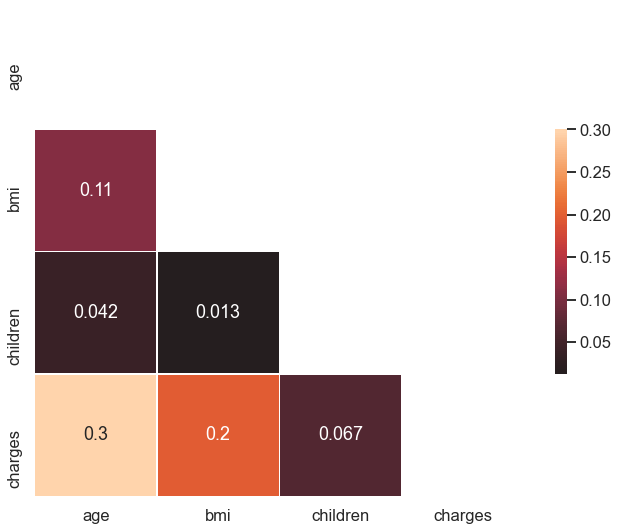

In [59]:
with sns.axes_style("white"):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr,
        mask=mask,
        vmax=0.3,
        center=0,
        square=True,
        annot=True,
        annot_kws={"size": 18},
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
    )

Zoom into the target-predictor variable pair with the largest correlation.

We observe an upward trend but there exist different clusters. 

In [60]:
fig = px.scatter(
    medical_df, x="age", y="charges", color="charges", size="bmi", hover_data=["bmi"]
)

fig.show()

# Feature engineering
## Numerical Variables
### Feature extraction

Here, we createed new set of features that correlate better with the target. That is these new set of features are more informative.

In [61]:
medical_df["charges_per_age"] = medical_df["charges"] / medical_df["age"]
medical_df["charges_per_bmi"] = medical_df["charges"] / medical_df["bmi"]

# medical_df["per_children_charges"] = medical_df["children"] / medical_df["charges"]
# medical_df["children_per_age"] = medical_df["children"] / medical_df["age"]

medical_df["charges_per_child"] = medical_df["charges"] / (1 + medical_df["children"])

corr = medical_df.corr()

corr["charges"].sort_values(ascending=False)

charges              1.000000
charges_per_bmi      0.959524
charges_per_age      0.845716
charges_per_child    0.793999
age                  0.298308
bmi                  0.198401
children             0.067389
Name: charges, dtype: float64

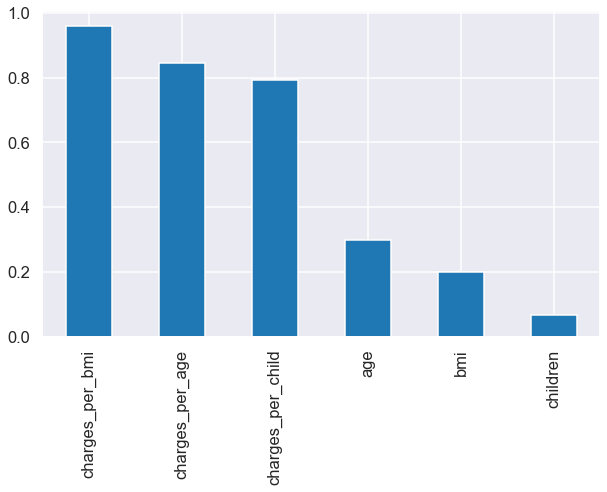

In [62]:
corr["charges"].abs().sort_values(ascending=False)[1:].plot(kind="bar")
plt.show()

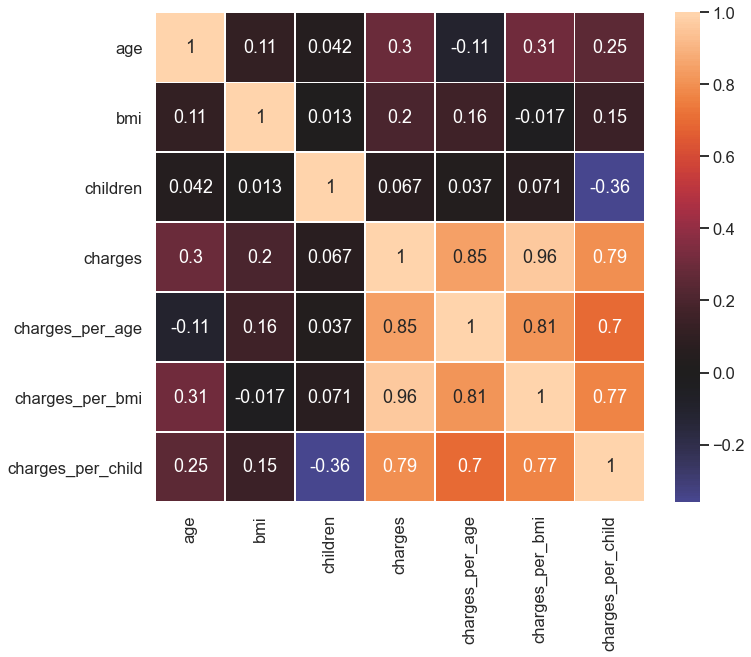

In [63]:
with sns.axes_style("white"):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr,
        square=True,
        center=0,
        annot=True,
        annot_kws={"size": 18},
        linewidths=0.5,
    )

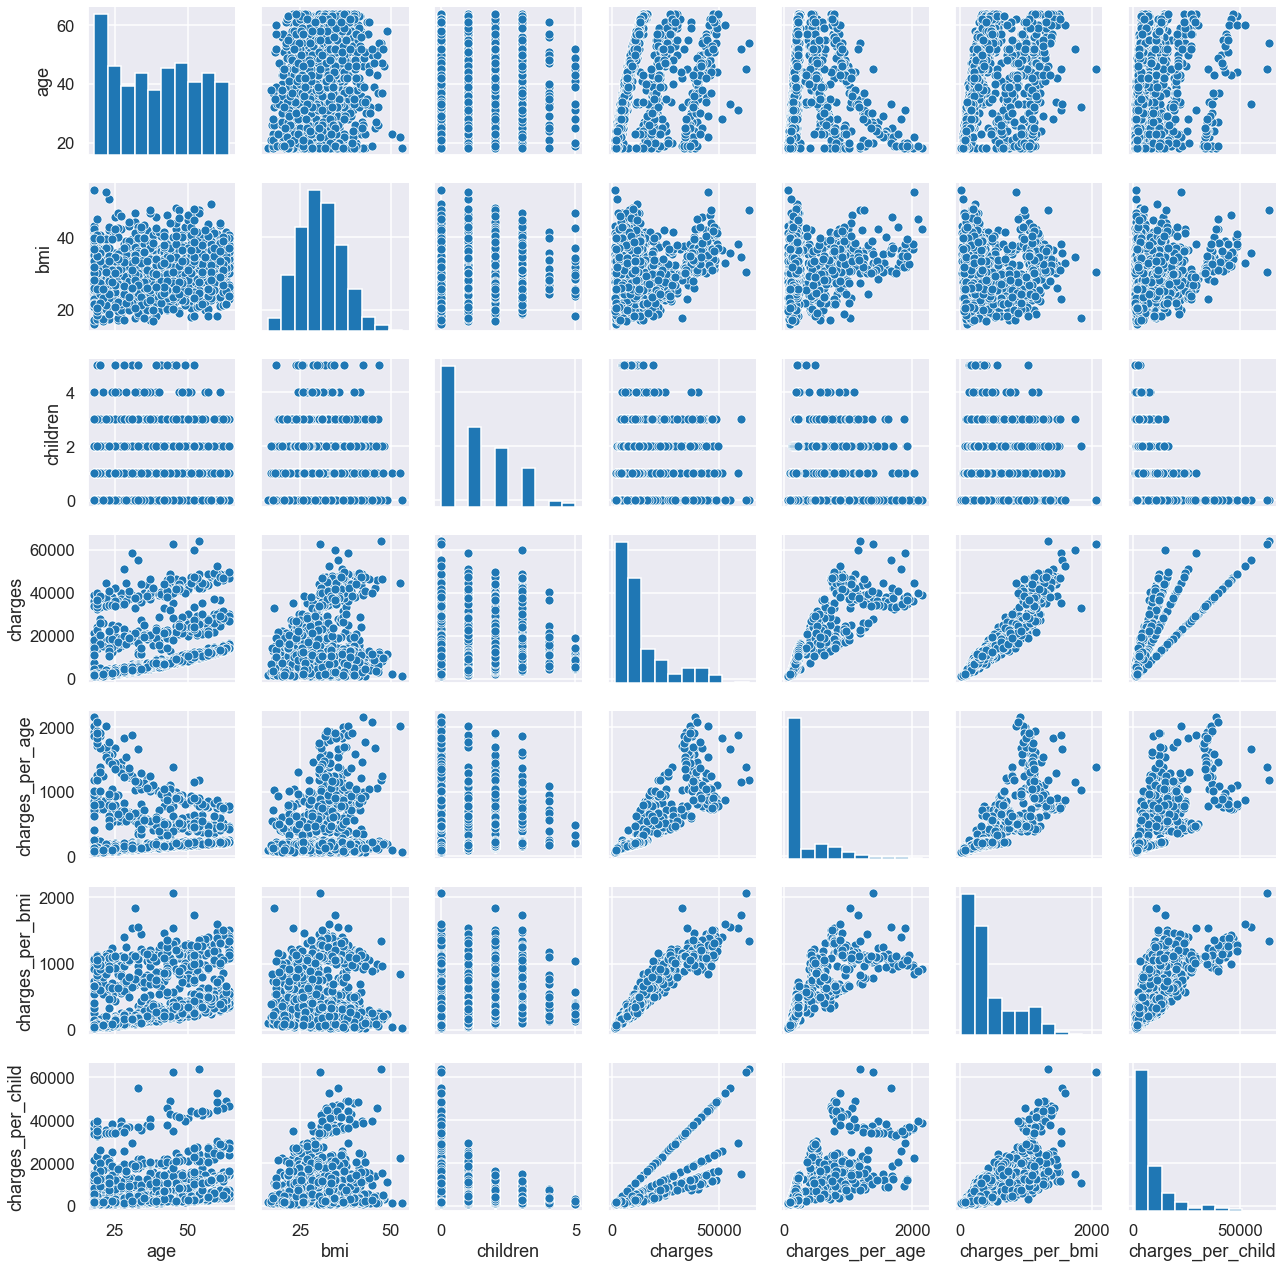

In [64]:
sns.set_context("talk")

sns.pairplot(medical_df)  # hue="children")

plt.show()

Here, we show the plot of the traget and new extracted feature

In [65]:
fig = px.scatter(
    medical_df,
    x="charges_per_age",
    y="charges",
    color="charges",
    size="bmi",
    hover_data=["bmi"],
)

fig.show()

In [66]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1337 non-null   int64  
 1   sex                1337 non-null   object 
 2   bmi                1337 non-null   float64
 3   children           1337 non-null   int64  
 4   smoker             1337 non-null   object 
 5   region             1337 non-null   object 
 6   charges            1337 non-null   float64
 7   charges_per_age    1337 non-null   float64
 8   charges_per_bmi    1337 non-null   float64
 9   charges_per_child  1337 non-null   float64
dtypes: float64(5), int64(2), object(3)
memory usage: 154.9+ KB


### Feature Scaling of numerical predictors

To speed-up the learning rate, the predictor variables will be scaled. More on this later


In [67]:
medical_df_copy = medical_df.copy()

scale_feature = medical_df.select_dtypes(include=["float64", "int64"]).columns.to_list()

scale_feature.remove("charges")

print(scale_feature)

scaler = StandardScaler()

medical_df[scale_feature] = scaler.fit_transform(medical_df[scale_feature])

medical_df[scale_feature].max()

['age', 'bmi', 'children', 'charges_per_age', 'charges_per_bmi', 'charges_per_child']


age                  1.764921
bmi                  3.684136
children             3.239729
charges_per_age      4.842878
charges_per_bmi      4.415988
charges_per_child    5.905605
dtype: float64

## Categorical Variables

One-hot encoding of the categorical variables

In [68]:
medical_df = pd.get_dummies(medical_df, columns=cat_col, drop_first=True)

medical_df.head()

,age,bmi,children,charges,charges_per_age,charges_per_bmi,charges_per_child,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.440418,-0.453160,-0.909234,16884.92400,1.439367,0.463701,0.916275,0,1,0,0,1
1,-1.511647,0.509422,-0.079442,1725.55230,-0.691249,-1.039875,-0.788725,1,0,0,1,0
2,-0.799350,0.383155,1.580143,4449.46200,-0.521820,-0.812655,-0.762165,1,0,0,1,0
3,-0.443201,-1.305052,-0.909234,21984.47061,0.841463,1.448917,1.458944,1,0,1,0,0
4,-0.514431,-0.292456,-0.909234,3866.85520,-0.624130,-0.815202,-0.469046,1,0,1,0,0


In [69]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1337 non-null   float64
 1   bmi                1337 non-null   float64
 2   children           1337 non-null   float64
 3   charges            1337 non-null   float64
 4   charges_per_age    1337 non-null   float64
 5   charges_per_bmi    1337 non-null   float64
 6   charges_per_child  1337 non-null   float64
 7   sex_male           1337 non-null   uint8  
 8   smoker_yes         1337 non-null   uint8  
 9   region_northwest   1337 non-null   uint8  
 10  region_southeast   1337 non-null   uint8  
 11  region_southwest   1337 non-null   uint8  
dtypes: float64(7), uint8(5)
memory usage: 130.1 KB


In [70]:
corr = medical_df.corr()

corr["charges"].sort_values(ascending=False)

charges              1.000000
charges_per_bmi      0.959524
charges_per_age      0.845716
charges_per_child    0.793999
smoker_yes           0.787234
age                  0.298308
bmi                  0.198401
region_southeast     0.073578
children             0.067389
sex_male             0.058044
region_northwest    -0.038695
region_southwest    -0.043637
Name: charges, dtype: float64

Visualize the correlation of the encoded variable with the target.

The smoker, feature column is very informative

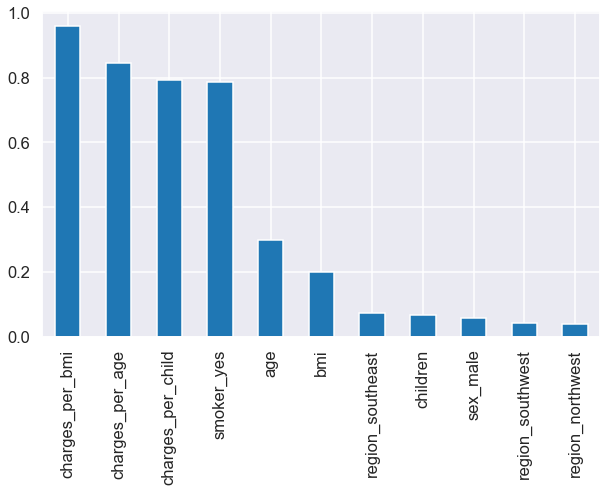

In [71]:
corr["charges"].abs().sort_values(ascending=False)[1:].plot(kind="bar")
plt.show()

What is the relative portion of smokers and non-smokers? Since, there is a huge disproportionality, we will have to do a stratified split 

In [72]:
medical_df["smoker_yes"].value_counts(normalize=True)

0    0.795064
1    0.204936
Name: smoker_yes, dtype: float64

In [73]:
col = corr["charges"].abs().sort_values(ascending=False)[1:]

selected_features = col[col > 0.5].index.to_list()
selected_features

['charges_per_bmi', 'charges_per_age', 'charges_per_child', 'smoker_yes']


## Model selection and training

## Train and test set 

In [74]:
X, y = medical_df[selected_features], medical_df["charges"]

# we stratify by the smoker_yes column to ensure that the train and test sets have the same proportion of smokers as the original dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=medical_df["smoker_yes"]
)

In [75]:
X_train["smoker_yes"].value_counts(normalize=True), X_test["smoker_yes"].value_counts(
    normalize=True
)

(0    0.795136
 1    0.204864
 Name: smoker_yes, dtype: float64,
 0    0.794776
 1    0.205224
 Name: smoker_yes, dtype: float64)

In [76]:
X_train.shape, type(X_train), X_train.max()

((1069, 4),
 pandas.core.frame.DataFrame,
 charges_per_bmi      4.415988
 charges_per_age      4.669599
 charges_per_child    5.905605
 smoker_yes           1.000000
 dtype: float64)

In [77]:
X_train_scaled = X_train

## Training and Evaluating on the Training Set

In [78]:
# batch gradient descent
lin_reg = LinearRegression()

lin_reg.fit(X_train_scaled, y_train)

y_pred = lin_reg.predict(X_train_scaled)

rmse = mean_squared_error(y_train, y_pred, squared=False)
rmse

2967.9623654876286

In [79]:
# stochastic gradient descent which is much faster but less accurate than the batch gradient descent above
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3,
                       penalty=None, eta0=0.1, random_state=42)

sgd_reg.fit(X_train_scaled, y_train)

y_pred = sgd_reg.predict(X_train_scaled)

rmse = mean_squared_error(y_train, y_pred, squared=False)
rmse

3026.202467139127

Without the applying the feature extraction and using all the predictor valrible, the rmse was $6056.44$. Hence feature scaling has significantly improve our performance. The score of the is not very great which point to a possible bias in our assumption of linearity. This is underfitting on the training data. We can improve this model by using a complicated algorithm or add more features to increase the complexity of the model. We will explore other models 

In [80]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)

tree_reg.fit(X_train_scaled, y_train)

y_pred = tree_reg.predict(X_train_scaled)

rmse = mean_squared_error(y_train, y_pred, squared=False)
rmse

0.0

It fits perfectly well to the training set which could possibly mean that it will be generalise well to unseen data. We further explored an additional model.

In [81]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

forest_reg.fit(X_train_scaled, y_train)

y_pred = forest_reg.predict(X_train_scaled)

rmse = mean_squared_error(y_train, y_pred, squared=False)

rmse

763.8075139662355

In [82]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X_train_scaled, y_train)

y_pred = svm_reg.predict(X_train_scaled)

rmse = mean_squared_error(y_train, y_pred, squared=False)

rmse

17174.137336227403

In [83]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")

svm_poly_reg1.fit(X_train_scaled, y_train)

y_pred = svm_poly_reg1.predict(X_train_scaled)

rmse = mean_squared_error(y_train, y_pred, squared=False)

rmse

6212.871035919829

### Model selection with cross validation
Now, to choose a better model, we use the cross validation techniques to see how the model will generalise to unseen data

In [84]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [85]:
# Linear Regression

lin_scores = cross_val_score(
    lin_reg, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=10
)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [3019.68964664 2873.05387446 2786.63547032 2806.55734592 2954.3939261
 2803.23645173 3206.35438462 3433.4843441  3299.44529603 2722.78524769]
Mean: 2990.5635987591077
Standard deviation: 231.59428921671253


In [86]:
# Decision Tree

scores = cross_val_score(
    tree_reg, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=10
)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [3328.63883115 1853.92149561 2123.85038448 1616.85500189 2693.52061905
 2696.92275065 2452.93193039 3775.49325138 4069.64744677 1756.45466041]
Mean: 2636.8236371787575
Standard deviation: 809.954709026619


In [87]:
# Random Forest

forest_scores = cross_val_score(
    forest_reg, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=10
)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [2757.08420174 1266.99998735 1611.80871151 1515.04890036 1528.68592496
 1547.10358478 2163.03061584 2593.02947846 2754.239144    995.45977233]
Mean: 1873.2490321328983
Standard deviation: 609.8500056277846


Since the model performs poorly on the training set, we increase the complexity of the model througn polynomial feature engineering but first we examine the generalization error

### Generalisation Error
The generalisation error is almost the same as the test error. Since both error are large it points to underfitting or bias of the model

In [88]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

forest_reg.fit(X_train_scaled, y_train)

y_pred = forest_reg.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)

rmse

1690.722410660548

### Dealing with underfitted model

Here, we try to increase the complexity of the by adding polynonial features and also extra features 

In [89]:
# medical_df_copy = pd.get_dummies(medical_df_copy, columns=cat_col, drop_first=True)

scale_feature_copy = medical_df_copy.select_dtypes(
    include=["float64", "int64"]
).columns.to_list()

scale_feature_copy.remove("charges")

print(scale_feature_copy)

medical_df_copy = pd.get_dummies(
    medical_df_copy, columns=cat_col, drop_first=True)

corr_copy = medical_df.corr()

col_copy = corr_copy["charges"].abs().sort_values(ascending=False)[1:]

['age', 'bmi', 'children', 'charges_per_age', 'charges_per_bmi', 'charges_per_child']


## Using all extracted features - RandomForest

This gives the best performace so far

In [90]:
# without polynomial but using
selected_features_copy = col_copy[col_copy > 0.01].index.to_list()

print("Used features: \n", selected_features_copy)
X, y = medical_df_copy[selected_features_copy], medical_df_copy["charges"]

# we stratify by the smoker_yes column to ensure that the train and test sets have the same proportion of smokers as the original dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=medical_df_copy["smoker_yes"]
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Random Forest
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

forest_scores = cross_val_score(
    forest_reg, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=10
)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Used features: 
 ['charges_per_bmi', 'charges_per_age', 'charges_per_child', 'smoker_yes', 'age', 'bmi', 'region_southeast', 'children', 'sex_male', 'region_southwest', 'region_northwest']
Scores: [1081.16618946  697.67285293  600.41941232 1461.96759476  528.03318673
  899.11771131 1464.01410757  749.56725045 1750.88078386  497.30798578]
Mean: 973.0147075168825
Standard deviation: 423.2331596782024


#### Generalization error - Best Error


In [91]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

forest_reg.fit(X_train_scaled, y_train)

y_pred = forest_reg.predict(X_test_scaled)

rmse = mean_squared_error(y_test, y_pred, squared=False)

rmse

728.4530367997106

The $95\%$ confidence interval is:

In [92]:
from scipy import stats

confidence = 0.95
squared_errors = (y_pred - y_test) ** 2
np.sqrt(
    stats.t.interval(
        confidence,
        len(squared_errors) - 1,
        loc=squared_errors.mean(),
        scale=stats.sem(squared_errors),
    )
)

array([544.66265038, 874.4313872 ])

### Using polynomial features

Here, we used the most correlated features together with new polynomial features and the performance gets worse without the polynomial features added.

In [93]:
# Adding polynomial features
selected_features_copy = col_copy[col_copy > 0.5].index.to_list()

print("Used features: \n", selected_features_copy)
X, y = medical_df_copy[selected_features_copy], medical_df_copy["charges"]

# we stratify by the smoker_yes column to ensure that the train and test sets have the same proportion of smokers as the original dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=medical_df_copy["smoker_yes"]
)

poly_features = PolynomialFeatures(degree=2)

X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)


print(X_train.shape, X_train_poly.shape)

scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Random Forest
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

forest_scores = cross_val_score(
    forest_reg, X_train_poly_scaled, y_train, scoring="neg_mean_squared_error", cv=10
)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Used features: 
 ['charges_per_bmi', 'charges_per_age', 'charges_per_child', 'smoker_yes']
(1069, 4) (1069, 15)
Scores: [2917.73146903 1336.14473173 1697.65744845 1524.54832531 1380.37122911
 1425.59039273 1870.56463732 2483.88586123 2804.08423219  849.11284986]
Mean: 1828.9691176957986
Standard deviation: 651.4416695393479


#### Generalization error


In [94]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

forest_reg.fit(X_train_poly_scaled, y_train)

y_pred = forest_reg.predict(X_test_poly_scaled)

rmse = mean_squared_error(y_test, y_pred, squared=False)

rmse

1532.5143621939592

## Dimensionality Reduction with 

### PCA
Reducing the dimensions from 10 to 4 worsen the performance as expected as we are dealing with a high bias model

### LLE
Locally Linear Embedding (LLE)8 is another very powerful nonlinear dimensionality
reduction (NLDR) technique. It is a Manifold Learning technique that does not rely
on projections like the previous algorithms.

## Multidimensional Scaling (MDS)
preserve the distances between the instances


## t-Distributed Stochastic Neighbor Embedding (t-SNE) 
reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space

In [129]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import LocallyLinearEmbedding, MDS, TSNE

# without polynomial but using
selected_features_copy = col_copy[col_copy > 0.01].index.to_list()

print("Used features: \n", selected_features_copy)
X, y = medical_df_copy[selected_features_copy], medical_df_copy["charges"]

pca = PCA(n_components=4)

# you can set n_components to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve:
# pca = PCA(n_components=0.99)

# randomized solver is used by default
# pca = PCA(n_components=10, svd_solver="randomized")

# pca = KernelPCA(n_components=4, kernel="rbf", gamma=0.04)
X = pca.fit_transform(X)

# lle = LocallyLinearEmbedding(n_components=4, n_neighbors=10)
# X = lle.fit_transform(X)


# embedding = MDS(n_components=4)
# X = embedding.fit_transform(X)


# embedding = TSNE(n_components=5, learning_rate="auto",
#                  init="random", method="exact")
# X = embedding.fit_transform(X)

# print("total variance explained: ", pca.explained_variance_ratio_.sum())
# print("n_components: ", pca.n_components_)

# we stratify by the smoker_yes column to ensure that the train and test sets have the same proportion of smokers as the original dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=medical_df_copy["smoker_yes"]
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Random Forest
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

forest_scores = cross_val_score(
    forest_reg, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=10
)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Used features: 
 ['charges_per_bmi', 'charges_per_age', 'charges_per_child', 'smoker_yes', 'age', 'bmi', 'region_southeast', 'children', 'sex_male', 'region_southwest', 'region_northwest']
Scores: [2028.40298153 1317.90560157 1236.65027447 1524.49272158 1060.38693898
 1672.16243993 1845.63331707 1824.26258948 3023.08795585 1391.47574394]
Mean: 1692.4460564406486
Standard deviation: 528.3037769258711


## Deep Learning

In [1]:
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Dense,
    Input,
    Dropout,
    Activation,
    Flatten,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
)
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

# Tensorflow untils packages.
# import tensorflow_docs as tfdocs
# import tensorflow_docs.plots
# import tensorflow_docs.modeling

tf.random.set_seed(42)
tf.debugging.set_log_device_placement(False)
print(tf.__version__)

2.6.2


In [334]:
# without polynomial but using
selected_features_copy = col_copy[col_copy > 0.01].index.to_list()

print("Used features: \n", selected_features_copy)
X, y = medical_df_copy[selected_features_copy], medical_df_copy["charges"]


# we stratify by the smoker_yes column to ensure that the train and test sets have the same proportion of smokers as the original dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=medical_df_copy["smoker_yes"]
)

Used features: 
 ['charges_per_bmi', 'charges_per_age', 'charges_per_child', 'smoker_yes', 'age', 'bmi', 'region_southeast', 'children', 'sex_male', 'region_southwest', 'region_northwest']


## No hidden layer in Neural Network

In [393]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train)

linear_model = Sequential([normalizer, Dense(units=1)])

linear_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=["mse", "mae"],
)

ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath="linear_model.h5",
    save_best_only=True,
    monitor="val_loss",
    save_weights_only=True,
    verbose=0,
)

with tf.device("/CPU:0"):
    history = linear_model.fit(
        X_train,
        y_train,
        epochs=1000,
        batch_size=10,
        # to view the logs, uncomment this:
        verbose=0,
        shuffle=True,
        # callbacks=[ckpt],
        # validation split: 20% of the training data.
        validation_split=0.2,
    )

Best Validation Loss: 1966.44774911514 at epoch: 982
Best Training Loss: 2042.2049358475265 at epoch: 672


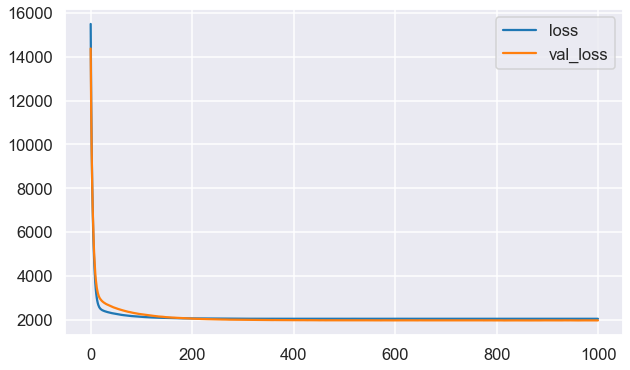

Generalization Loss: 2063.2091379391845


In [394]:
def plot_loss(history):
    plt.plot(np.sqrt(history.history["loss"]), label="loss")
    plt.plot(np.sqrt(history.history["val_loss"]), label="val_loss")
    print(
        "Best Validation Loss:",
        np.sqrt(history.history["val_loss"]).min(),
        "at epoch:",
        np.argmin(history.history["val_loss"]) + 1,
    )
    print(
        "Best Training Loss:",
        np.sqrt(history.history["loss"]).min(),
        "at epoch:",
        np.argmin(history.history["loss"]) + 1,
    )
    plt.legend()
    plt.grid(True)
    plt.show()


plot_loss(history)

y_pred = linear_model.predict(X_test)
print("Generalization Loss:", np.sqrt(mean_squared_error(y_test, y_pred)))

The performance is a worse than the random forest model due to the simplicity of this network. Since it is bias, we need to increase the complexity of the model

## Using a single hidden layer NN with many neurons/units

In [391]:
output_size = 1
hidden_layer = 350
input_size = 1
learning_rate = 0.051
loss_function = "mean_squared_error"
epochs = 1000  # 170
batch_size = 11

tf.keras.backend.clear_session()

tf.random.set_seed(42)
model = Sequential(normalizer)
# model.add(Dense(hidden_layer, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(hidden_layer, activation="selu", kernel_initializer="lecun_normal"))

# Regularization
# model.add(Dropout(0.2))
# model.add(
#     Dense(
#         hidden_layer,
#         activation="selu",
#         kernel_initializer="lecun_normal",
#         kernel_regularizer=tf.keras.regularizers.l1(0.01),
#     )
# )

model.add(Dense(output_size))

model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss_function)
# model.compile(tf.keras.optimizers.RMSprop(learning_rate=learning_rate), loss=loss_function)
# model.compile(tf.keras.optimizers.Nadam(learning_rate=learning_rate), loss=loss_function)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1,
    shuffle=True,
)

Epoch 1/1000
78/78 [==============================] - 1s 7ms/step - loss: 230889120.0000 - val_loss: 85451920.0000
Epoch 2/1000
78/78 [==============================] - 0s 3ms/step - loss: 26626216.0000 - val_loss: 12929904.0000
Epoch 3/1000
78/78 [==============================] - 0s 3ms/step - loss: 8130242.0000 - val_loss: 6747537.5000
Epoch 4/1000
78/78 [==============================] - 0s 2ms/step - loss: 4222654.0000 - val_loss: 4069594.2500
Epoch 5/1000
78/78 [==============================] - 0s 2ms/step - loss: 2249213.0000 - val_loss: 2303101.5000
Epoch 6/1000
78/78 [==============================] - 0s 2ms/step - loss: 1429683.5000 - val_loss: 1957821.1250
Epoch 7/1000
78/78 [==============================] - 0s 2ms/step - loss: 1109440.6250 - val_loss: 1952960.8750
Epoch 8/1000
78/78 [==============================] - 0s 2ms/step - loss: 929042.5625 - val_loss: 1063457.7500
Epoch 9/1000
78/78 [==============================] - 0s 2ms/step - loss: 712797.8125 - val_loss: 16

Best Validation Loss: 223.50294496102282 at epoch: 877
Best Training Loss: 43.54283681267577 at epoch: 967


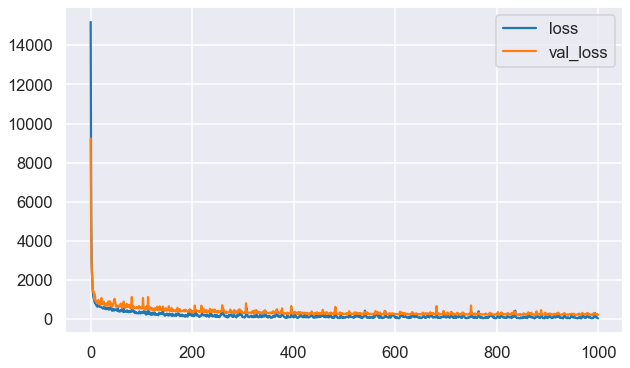

Generalization Loss: 156.91000874120917


In [392]:
plot_loss(history)
y_pred = model.predict(X_test)
print("Generalization Loss:", np.sqrt(mean_squared_error(y_test, y_pred)))

The performance of a single layer NN is better than the random forest ML model. Can we still beat this performance.

## Using double hidden layers in NN

In [395]:
model = Sequential(normalizer)
model.add(Dense(30, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(45, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(output_size))

model.compile(tf.keras.optimizers.Adam(
    learning_rate=learning_rate), loss=loss_function)
epochs = 1000

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/1000
78/78 [==============================] - 1s 5ms/step - loss: 126975368.0000 - val_loss: 8209876.5000
Epoch 2/1000
78/78 [==============================] - 0s 3ms/step - loss: 4965947.5000 - val_loss: 4831948.0000
Epoch 3/1000
78/78 [==============================] - 0s 3ms/step - loss: 3154104.5000 - val_loss: 3846101.0000
Epoch 4/1000
78/78 [==============================] - 0s 2ms/step - loss: 2605412.0000 - val_loss: 3260477.5000
Epoch 5/1000
78/78 [==============================] - 0s 2ms/step - loss: 2366682.2500 - val_loss: 2264658.5000
Epoch 6/1000
78/78 [==============================] - 0s 2ms/step - loss: 2039603.6250 - val_loss: 2604933.7500
Epoch 7/1000
78/78 [==============================] - 0s 2ms/step - loss: 1976048.0000 - val_loss: 2826449.0000
Epoch 8/1000
78/78 [==============================] - 0s 3ms/step - loss: 1733931.8750 - val_loss: 2078193.5000
Epoch 9/1000
78/78 [==============================] - 0s 3ms/step - loss: 1725470.0000 - val_loss: 555

Best Validation Loss: 228.36122187501536 at epoch: 900
Best Training Loss: 106.8244717910531 at epoch: 949


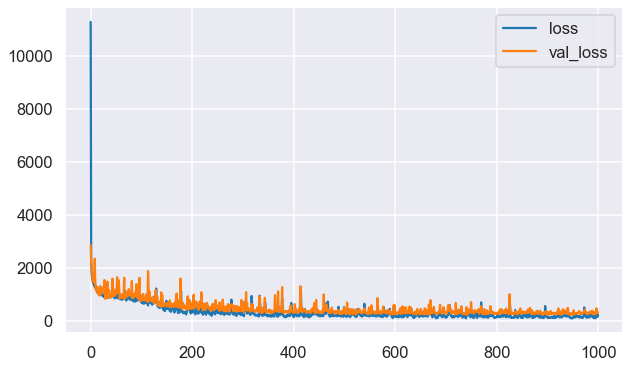

Generalization Loss: 239.70744977983148


In [396]:
plot_loss(history)

y_pred = model.predict(X_test)
print("Generalization Loss:", np.sqrt(mean_squared_error(y_test, y_pred)))

## Interpretation - Insights

Since I am using a black-box model neural network I resort to using a surrogate model

In [417]:
output_size = 1
hidden_layer = 350
input_size = 1
learning_rate = 0.051
loss_function = "mean_squared_error"
epochs = 1000  # 170
batch_size = 11

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


tf.keras.backend.clear_session()

tf.random.set_seed(42)

model = Sequential()

model.add(Dense(hidden_layer, activation="selu",
          kernel_initializer="lecun_normal"))

model.add(Dense(output_size))

model.compile(tf.keras.optimizers.Adam(
    learning_rate=learning_rate), loss=loss_function)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1,
    shuffle=True,
)

Epoch 1/1000
78/78 [==============================] - 1s 6ms/step - loss: 230889120.0000 - val_loss: 85451960.0000
Epoch 2/1000
78/78 [==============================] - 0s 3ms/step - loss: 26626222.0000 - val_loss: 12929904.0000
Epoch 3/1000
78/78 [==============================] - 0s 3ms/step - loss: 8130236.0000 - val_loss: 6747537.5000
Epoch 4/1000
78/78 [==============================] - 0s 2ms/step - loss: 4222650.5000 - val_loss: 4069593.5000
Epoch 5/1000
78/78 [==============================] - 0s 3ms/step - loss: 2249208.7500 - val_loss: 2303105.5000
Epoch 6/1000
78/78 [==============================] - 0s 3ms/step - loss: 1429693.1250 - val_loss: 1957904.6250
Epoch 7/1000
78/78 [==============================] - 0s 2ms/step - loss: 1109519.2500 - val_loss: 1952988.5000
Epoch 8/1000
78/78 [==============================] - 0s 2ms/step - loss: 929428.8750 - val_loss: 1063404.7500
Epoch 9/1000
78/78 [==============================] - 0s 3ms/step - loss: 713087.0000 - val_loss: 16

In [418]:
y_pred = model.predict(X_test_scaled)
print("Generalization Loss:", np.sqrt(mean_squared_error(y_test, y_pred)))

Generalization Loss: 161.63100829354005


In [419]:
y_pred_train = model.predict(X_train_scaled)
print("Training Loss:", np.sqrt(mean_squared_error(y_train, y_pred_train)))

Training Loss: 128.64833360360544


In [426]:
lin_reg = LinearRegression()


# train interpretable model with linear regression
surrogate_model = lin_reg.fit(X_train_scaled, y_pred_train)

y_pred_sur = surrogate_model.predict(X_train_scaled)

r2_metric = r2_score(y_pred_sur, y_pred_train)

r2_metric

0.9722748159070899

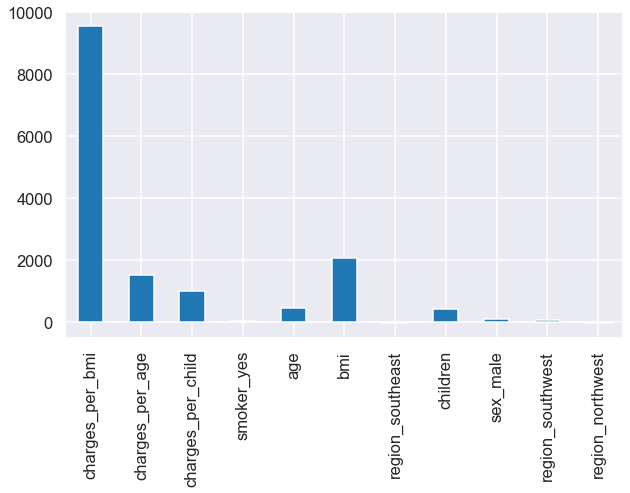

In [421]:
feature = pd.DataFrame(surrogate_model.coef_.T, index=selected_features_copy)

feature.plot(kind="bar", legend=False)

plt.show()

## General remarks

Since the 